# AutoEncoder

An AutoEncoder is a pair of two parametric function $g_{\theta_1}:R^n \rightarrow R^p$ and $f_{\theta_2}: R^p \rightarrow R^n$ such that, usually, $n >> p$.
The elements $x \in R^n$ are our data and when learning an autoencoder, we learn parameters $\theta_1$ and $\theta_2$ by minimizing $||f(g(x))-x||^2$ .

We therefore try to reduce the dimensionality of our data. $R^p$ is often called latent space. In the following we will try to learn autoencoder on images. The aim, if the model is well trained, is to get enough information in the latent space to generate a new image as close as possible to the original one.


In [1]:
import importlib.util
import sys
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My\ Drive/Colab\ Notebooks/cours_dlia/practical_sessions/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/cours_dlia/practical_sessions


In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow.keras

print(tf.__version__)

from scipy.stats import norm
from scipy.ndimage.morphology import distance_transform_edt
from sklearn import manifold, decomposition

from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist

1.15.0


Let's simulate a toy dataset. We define 1000 frames (28x28) and we randomly sample two points in these frames (one in the first column and one in the last column, but for two different random rows). We will compute a mask around these two coordinates. Our images consist in two disks randomly localized along the two edges of the frame.

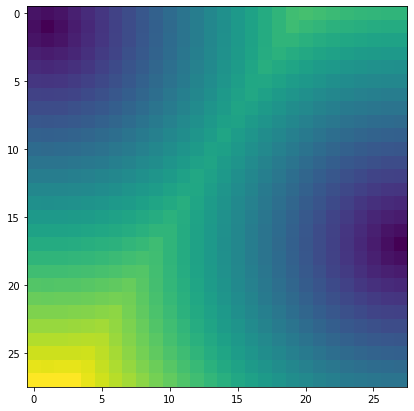

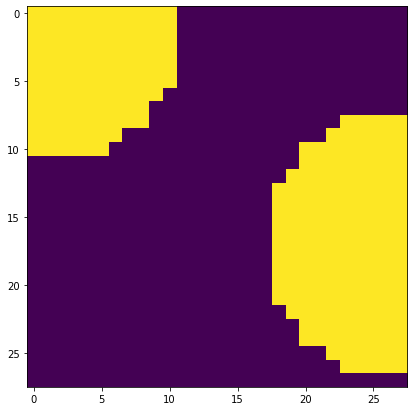

In [4]:
listOut = []
listA = []
listB = []

for i_frame in range(1000):
    # initialize the frame
    X = np.zeros([28,28])

    # randomly sample the rows of the two points A and B
    a = np.random.randint(28)
    X[a, 1] = 1
    b = np.random.randint(28)
    X[b, 27] = 1

    # we define a distance map around this two points...
    distance_map = distance_transform_edt(X==0)

    # ... and a mask (less than 10 pixels from the points)
    mask = distance_map < 10

    listOut.append(mask)
    listA.append(a)
    listB.append(b)

# plot the last distance map and the last mask simulated
plt.figure(figsize=(7, 7))
plt.imshow(distance_map)
plt.show()
plt.figure(figsize=(7, 7))
plt.imshow(mask)
plt.show()

We can plot the random rows coordinates sample for each images. Ideally, this is a representation of what could be our latent space. Only from that information (the random row coordinates of the two disks in each frame), we can generate again the original images.

In [2]:
plt.figure(figsize=(10, 10))
plt.plot(listA, listB, '.')
plt.title("Fig1 : A representation of the dataset", fontsize=20)
plt.xlabel('Row number')
plt.ylabel('Column number')
plt.show()

NameError: name 'plt' is not defined

We format the training set of images we will use to feed the autoencoder.

In [6]:
listOut = np.array(listOut)

# we want images with shape (batch_size, height, width, channel)
print("original shape", listOut.shape, listOut.dtype)
listOut = np.expand_dims(listOut, axis=3) * 1
listOut = listOut.astype('float32')
print("final shape", listOut.shape, listOut.dtype)

original shape (1000, 28, 28) bool
final shape (1000, 28, 28, 1) float32


Let's create an AutoEncoder class.

In [7]:
class AutoEncoder:
    
    def __init__(self, batch_size=50, filters=16, latent_dim=2, kernel_conv=3, 
                 img_chan=1,verbose=True):
        """
        Argument:
            batch_size = size of the batch to use during training
            input_dim = dimension of the input image. Have to be squared and in grayscales
            latent_dim = size of the latent space (dimensions of the reducted space)
            kernel_conv = size of the convolutional kernels
            img_chan = number of channels of the input image
            verbose = Boolean, if True, will print information about the models
        """
        
        input_dim = 28
        self.input_dim = (input_dim, input_dim, img_chan)
        self.batch_size = batch_size
        self.filters = filters
        self.latent_dim = latent_dim
        self.kernel_conv = kernel_conv
        self.verbose = verbose
                 
        ## We initialize the encoder:
        x = Input(shape=self.input_dim, 
                  name='main_input')
        conv_1 = Conv2D(img_chan, 
                        kernel_size=(2, 2),
                        padding='same', 
                        activation='relu')(x)
        conv_2 = Conv2D(filters,
                        kernel_size=(2, 2),
                        padding='same', 
                        activation='relu',
                        strides=(2, 2))(conv_1)
        conv_3 = Conv2D(filters,
                        kernel_size=kernel_conv,
                        padding='same', 
                        activation='relu',
                        strides=1)(conv_2)
        conv_4 = Conv2D(filters,
                        kernel_size=kernel_conv,
                        padding='same', 
                        activation='relu',
                        strides=1)(conv_3)
        flat = Flatten()(conv_4)
        hidden = Dense(latent_dim, 
                       activation='relu')(flat)
        self.encoder = Model(x, 
                             outputs=hidden, 
                             name='encoder')
        if self.verbose:
            self.encoder.summary()
            
        ## We initialize the decoder: it will map a point z of the latent space 
        ## toward the data space.
        output_shape = (batch_size, int(input_dim/2), int(input_dim/2), filters)
        z = Input(shape=(latent_dim,), 
                  name='decoder_input')
        z_hid = Dense(filters*2, 
                      activation='relu')(z)
        z_upsample = Dense(filters*(int(input_dim/2))*(int(input_dim/2)), 
                           activation='relu')(z_hid)
        z_reshape = Reshape(output_shape[1:])(z_upsample)
        z_deconv_1 = Conv2DTranspose(filters, 
                                     kernel_size=(kernel_conv, kernel_conv), 
                                     padding='same', 
                                     strides=(2, 2), 
                                     activation='relu')(z_reshape)
        z_decode = Conv2D(1, 
                          kernel_size=(1,1), 
                          padding='same', 
                          strides=(1,1), 
                          activation='relu')(z_deconv_1)
        self.decoder = Model(z, 
                             outputs=z_decode, 
                             name='decoder')
        if self.verbose:
            self.decoder.summary()
            
        ## Create the AutoEncoder model: retirer la réponse
        self.autoencoder = Model(x, 
                                 outputs=self.decoder(self.encoder(x)),
                                 name="autoencoder")
        
        ## Compile it: find an appropriate loss function
        ## See https://keras.io/models/model/ to find it
        
        loss_ =  # ANSWER HERE
        self.autoencoder.compile(optimizer='adam', loss=loss_)
        self.autoencoder.summary()
        
    def train(self, data, epochs):
        self.autoencoder.fit(x=data, 
                             y=data, 
                             shuffle=True, 
                             epochs=epochs, 
                             batch_size=self.batch_size)
        
    def plot_decode(self, z):
        # decode an image
        image_decoded = self.decoder.predict(np.expand_dims(z, axis=0))
        image_decoded = np.array(image_decoded)[0, :, :, 0]

        plt.figure(figsize=(7, 7))
        plt.imshow(image_decoded)
        plt.show()

SyntaxError: ignored

We instanciate a first autoencoder with a latent space of dimension 2.

In [0]:
ae = AutoEncoder(verbose=False)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 2)                 10999     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         105921    
Total params: 116,920
Trainable params: 116,920
Non-trainable params: 0
_________________________________________________________________


In [0]:
ae.train(data=listOut, epochs=50)

Epoch 1/50
1000/1000 [==============================] - 1s 1ms/step - loss: 0.3284
Epoch 2/50
1000/1000 [==============================] - 0s 270us/step - loss: 0.1958
Epoch 3/50
1000/1000 [==============================] - 0s 263us/step - loss: 0.1761
Epoch 4/50
1000/1000 [==============================] - 0s 261us/step - loss: 0.1702
Epoch 5/50
1000/1000 [==============================] - 0s 258us/step - loss: 0.1466
Epoch 6/50
1000/1000 [==============================] - 0s 261us/step - loss: 0.1186
Epoch 7/50
1000/1000 [==============================] - 0s 252us/step - loss: 0.1071
Epoch 8/50
1000/1000 [==============================] - 0s 258us/step - loss: 0.1018
Epoch 9/50
1000/1000 [==============================] - 0s 243us/step - loss: 0.0982
Epoch 10/50
1000/1000 [==============================] - 0s 252us/step - loss: 0.0963
Epoch 11/50
1000/1000 [==============================] - 0s 247us/step - loss: 0.0948
Epoch 12/50
1000/1000 [==============================] - 0s 251us

In [1]:
latent_variable_1 = 10
latent_variable_2 = 2
ae.plot_decode([latent_variable_1, latent_variable_2])

NameError: name 'ae' is not defined

Not that great ? But how did you choose the values of the latent variables ? 

We can now have a look at the latent space and see how the AE encodes data.

In [0]:
# projection in the latent space of all our simulted images
proj = ae.encoder.predict(listOut)

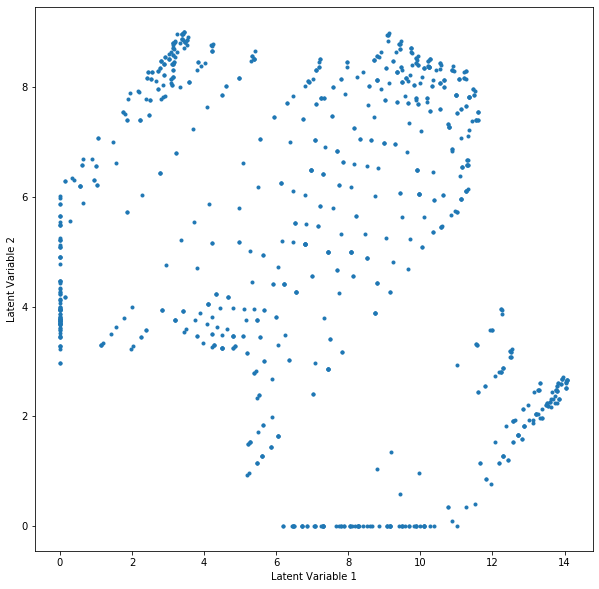

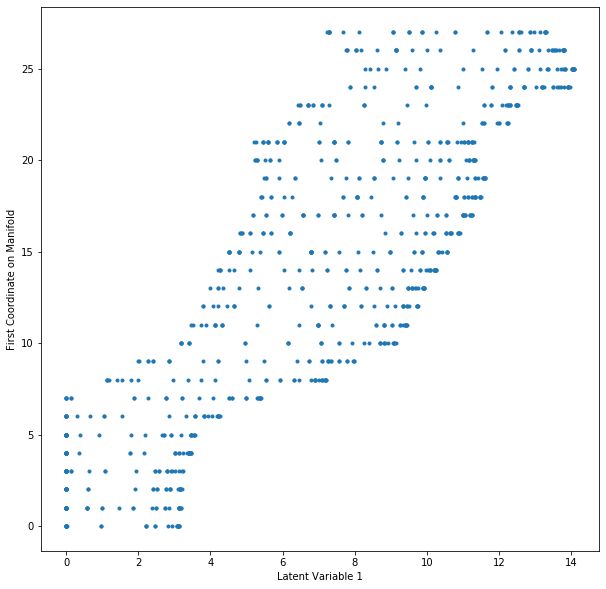

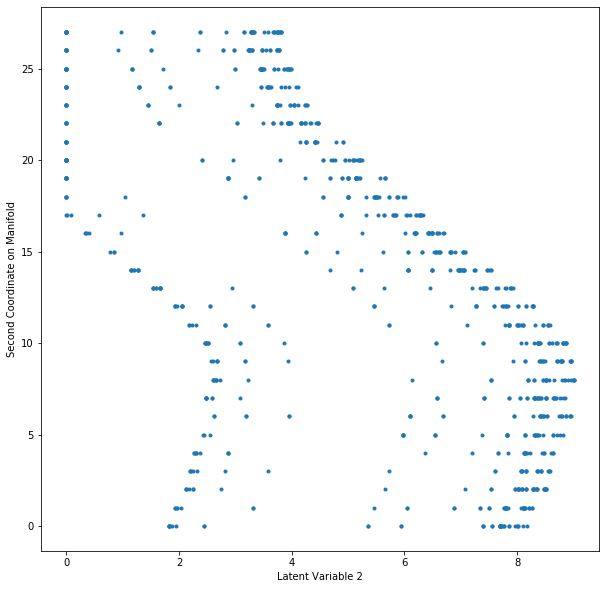

In [0]:
plt.figure(figsize=(10, 10))
plt.plot(proj[:,0], proj[:,1], '.')
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(proj[:,0], listA, '.')
plt.xlabel('Latent Variable 1')
plt.ylabel('First Coordinate on Manifold')
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(proj[:,1], listB, '.')
plt.xlabel('Latent Variable 2')
plt.ylabel('Second Coordinate on Manifold')
plt.show()

__Question__: Compare the plot of fig1 with the latent variables plot (the first one). What do you observe ? Is it normal ?  
__Answer__:

AE can be used in order to denoize an image. This task is done through the dimensionality reduction.
But it can also be used in order to generate data, that is, to sample new points coming from the same distribution as the input images.

The most straightforward way of doing so is to pick an element of the latent space and decode it. 
Let's try to decode a portion of the latent space ! 

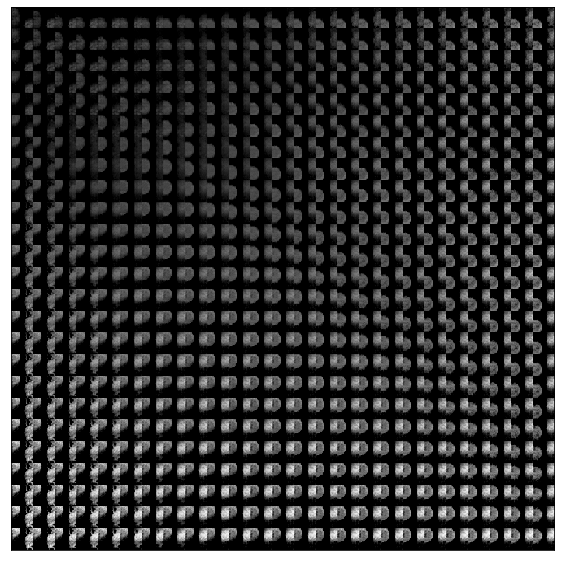

In [0]:
n = 25
digit_size = 28
frame = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0, 25, n)
grid_y = np.linspace(0, 25, n)

# we explore different point of the latent space and plot their decoded images
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, 1).reshape(1, 2)
        x_decoded = ae.decoder.predict(z_sample, batch_size=1)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        #print(digit)
        frame[i * digit_size: (i + 1) * digit_size,j * digit_size: (j + 1) * digit_size] = digit

# plot
plt.figure(figsize=(10, 10))
plt.imshow(frame, cmap='Greys_r')
plt.xticks([])
plt.yticks([])
plt.show()

# Let's do the same with images a bit more complex : digits.

In [0]:
# load MNIST dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = np.expand_dims(X_train, axis=3)
print(X_train.shape, X_train.dtype)

(60000, 28, 28, 1) uint8


We increase the size of the latent space because we expect the MNIST dataset to contain a more complex information.

In [0]:
ae = AutoEncoder(latent_dim=10, verbose=False)
ae.train(data=X_train, epochs=20) ## 2 Minutes training, you can either increase or decrease the epochs parameter depending on your patience.

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 10)                36095     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         106177    
Total params: 142,272
Trainable params: 142,272
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
60000/60000 [==============================] - 17s 291us/step - loss: 1974.6542
Epoch 2/100
60000/60000 [==============================] - 16s 266us/step - loss: 1380.3060
Epoch 3/100
60000/60000 [==============================] - 16s 264us/step - loss: 1272.1785
Epoch 4/100
60000/60000 [==============================] - 16s 264us/step - loss: 1220.3896
Epoch 5/100

We can now compare the original images with the generated ones.

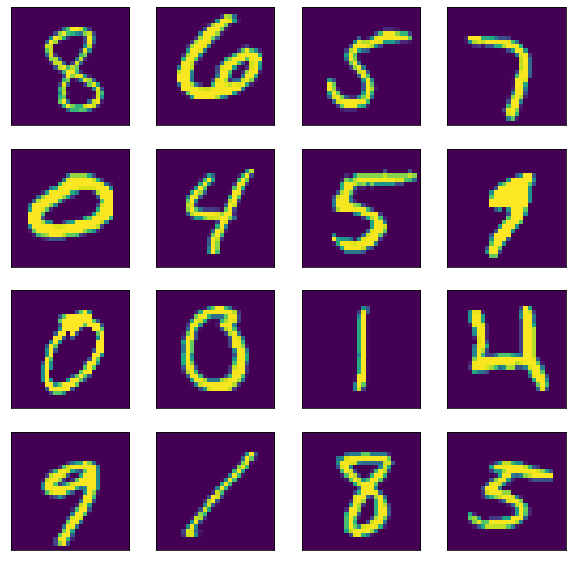

In [0]:
# original images
figure = plt.figure(figsize=(10, 10))
for i in range(16):
    original_image = X_train[np.random.randint(len(X_train))]
    plt.subplot(4, 4, i+1)
    plt.imshow(original_image[:, :, 0])
    plt.xticks([])
    plt.yticks([])
plt.show()

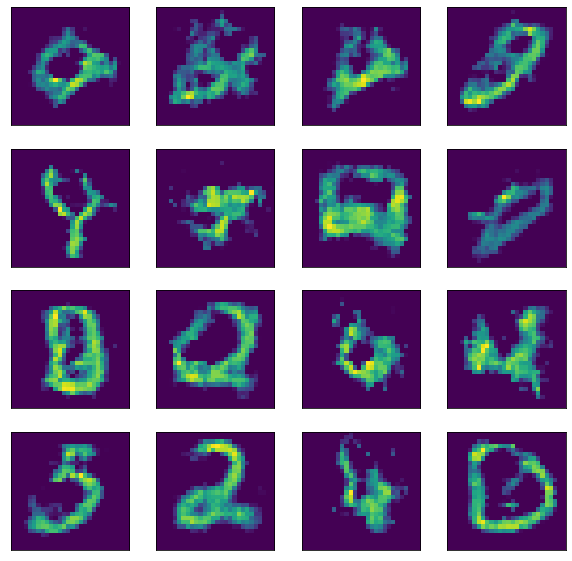

In [0]:
# generated images
figure = plt.figure(figsize=(10, 10))
for i in range(16):
    # sample a random vector of size 10
    z_coordinate = np.random.randint(10000, size=10)
    image_decoded = ae.decoder.predict(np.expand_dims(z_coordinate, axis=0))
    plt.subplot(4, 4, i+1)
    plt.imshow(image_decoded[0, :, :, 0])
    plt.xticks([])
    plt.yticks([])
plt.show()

In order to explore the latent space and get some intuitions about the potential structures it learned, we vizualize the latent representation of the original images.

In [0]:
latent_codes = ae.encoder.predict(X_train)
print(latent_codes.shape, latent_codes.dtype)

(60000, 10) float32


We visualise the projection of the training set on the latent space with a PCA.


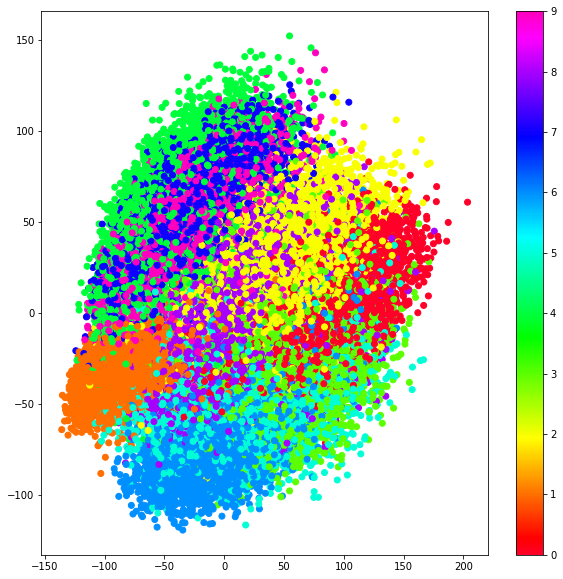

In [0]:
pca_latent = decomposition.PCA().fit_transform(latent_codes)

# plot (the colors represent the classes)
plt.figure(figsize=(10, 10))
plt.scatter(pca_latent[:,0], pca_latent[:,1], c=y_train, cmap='gist_rainbow')
plt.colorbar()
plt.show()

Now let's visualise it with t-SNE, a dimension reduction technique that keeps better trace of the initial distance between points.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.128s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 19.864048
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.297935
[t-SNE] KL divergence after 1000 iterations: 0.982962


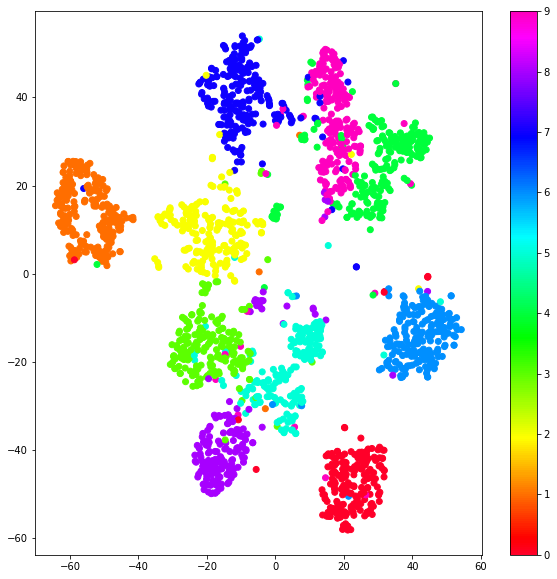

In [0]:
tsne = manifold.TSNE(n_iter=1000, verbose=1)
tsne_latent = tsne.fit_transform(latent_codes[:2000, :])

# plot
plt.figure(figsize=(10, 10))
plt.scatter(tsne_latent[:,0], tsne_latent[:,1], c=y_train[:2000], cmap='gist_rainbow')
plt.colorbar()
plt.show()

We can see that in the latent space the different digits clusterise quite well. You can observe that a proximity between images leads to a proximity in the latent space. We therefore know that if we feed the decoder with a point inside one of these clusters, we would probably get a simulation of the associated digit. However nothing assures us that if we sample a point in the latent space between these clusters, we will get a meaningful output from the decoder. Let's try to interpolate the points in the latent space and decode them!


In [0]:
# we get the indexes of the first samples corresponding to two different classes
index_c1 = list(y_train).index(3)
index_c2 = list(y_train).index(4)

# we get the respective coordinates in the latent space
z1 = latent_codes[index_c1]
z2 = latent_codes[index_c2]

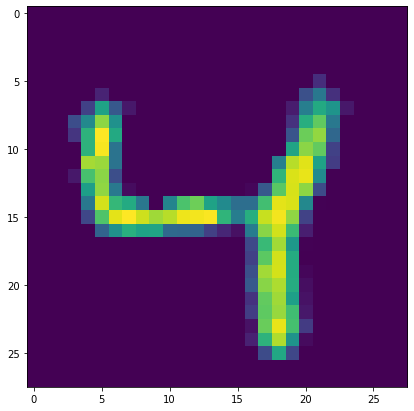

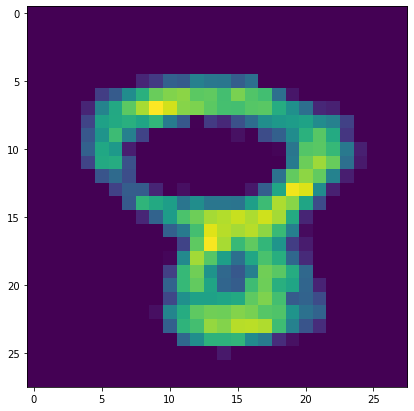

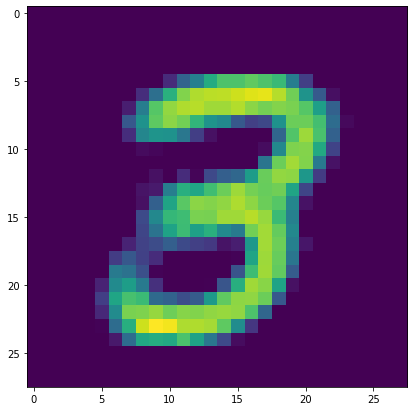

In [0]:
## Excercise : take a point along the segment [z1, z2] and decode it !
alpha = 0.1
z_int =  # complete HERE !!
ae.plot_decode(z_int)

alpha = 0.5
z_int = # complete HERE !!
ae.plot_decode(z_int)

alpha = 0.9
z_int = # complete HERE !!
ae.plot_decode(z_int)

In [0]:
## Exercise : take several points along the segment [z1, z2] and decode them !

# plot
plt.figure(figsize=(10, 10))
for i, alpha in enumerate(np.arange(0, 1, 0.01)):
    plt.subplot(10, 10, i+1)
    plt.axis('off')
    z_int =  # Complete HERE !!
    image_decoded = # Complete HERE !!
    plt.imshow(image_decoded[0, :, :, 0])

plt.subplots_adjust(wspace=0, hspace=0)

The inperolation works quite well. As you can see for some digits pairs, parts of the segment joining them may not look like handwritten digits but just an in-between, as if the original digits where fading into each others.

In fact, a simple autoencoder will "overfit" in the sense that when learning to encode and decode points, the functions are allowed to output anything between these training points. The **Variational AutoEncoders** have been introduced in order to face that problem: they will learn to encode an image not with a point, but with a distribution in the latent space.


They will play the exact same role as an autoencoder, but with "regularization", giving the latent space some wanted properties such as smoothness or completeness.

